## Exploración de datos

In [78]:
import pandas as pd
import numpy as np
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [56]:
## datos
Sureste_Crudos= r"C:\Users\REPO\Tec2025\Multivariados\Sureste Crudos.csv"
df_sureste_crudos = pd.read_csv(Sureste_Crudos)
df_sureste_crudos

,date,CO,NO,NO2,NOX,O3,PM10,PM2.5,PRS,RAINF,RH,SO2,SR,TOUT,WSR,WDR
0,1/1/2020 0:00,NaN,NaN,NaN,NaN,NaN,66.0,54.23,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN
1,1/1/2020 1:00,2.11,NaN,NaN,NaN,19.0,57.0,NaN,735.7,0.00,96.0,5.4,0.010,11.20,8.1,NaN
2,1/1/2020 2:00,2.06,NaN,NaN,NaN,19.0,68.0,53.84,734.8,0.00,96.0,5.5,0.010,11.26,5.5,NaN
3,1/1/2020 3:00,1.96,NaN,NaN,NaN,19.0,68.0,36.47,734.2,0.00,96.0,5.4,0.010,11.35,3.8,NaN
4,1/1/2020 4:00,1.98,NaN,NaN,NaN,16.0,48.0,33.59,733.9,0.00,96.0,5.5,0.010,11.47,3.3,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44506,6/30/2025 19:00,0.57,3.4,5.8,9.2,16.0,15.0,6.75,722.1,0.01,88.0,2.0,0.024,22.75,15.4,106.0
44507,6/30/2025 20:00,0.60,3.3,6.2,9.6,16.0,19.0,5.19,722.5,0.00,89.0,2.1,0.003,22.72,17.0,101.0
44508,6/30/2025 21:00,0.54,3.0,5.3,8.3,17.0,18.0,4.36,722.7,0.16,88.0,1.9,0.000,22.60,15.9,108.0
44509,6/30/2025 22:00,0.47,2.6,3.9,6.6,19.0,15.0,3.91,722.9,0.09,90.0,2.0,0.000,22.21,18.5,102.0


In [57]:
# Características del data set  

def caracteristicas_Dataset(csv_path, freq=None, date_format="%m/%d/%Y %I:%M:%S %p", dayfirst=False):
    """
    Lee un CSV cuyo PRIMERA columna es fecha-hora tipo '1/1/2020  12:00:00 AM',
    crea columnas 'date' y 'time', infiere frecuencia, reindexa a la malla completa
    y reporta faltantes de dos tipos:
      - was_missing_timestamp: timestamps que no existían (filas completas ausentes)
      - has_missing_values: filas presentes con NaNs en alguna métrica

    Params:
        csv_path: ruta al CSV
        freq: frecuencia deseada (ej. 'H', 'D', '15T'); si None, intenta inferir
        date_format: formato esperado principal (EE.UU. AM/PM por default)
        dayfirst: si quieres fallback con día-primero en la inferencia

    Returns:
        df_full: DataFrame con índice datetime completo y etiquetas de faltantes
        report: dict con conteos/resumen
    """
    # 1) Leer
    df = pd.read_csv(csv_path)

    if df.shape[1] == 0:
        raise ValueError("CSV vacío o sin columnas.")

    first_col = df.columns[0]

    # 2) Normalizar y parsear la primera columna como datetime (maneja dobles espacios)
    s = df[first_col].astype(str).str.strip().str.replace(r"\s+", " ", regex=True)

    dt = pd.to_datetime(s, format=date_format, errors="coerce")
    # Fallback: intento genérico (por si alguna fila viene en otro formato)
    if dt.isna().any():
        dt2 = pd.to_datetime(s, errors="coerce", dayfirst=dayfirst)
        dt = dt.fillna(dt2)

    if dt.isna().all():
        raise ValueError("No se pudo parsear la primera columna como datetime.")

    df = df.drop(columns=[first_col])  # ya no necesitamos la original textual
    df.insert(0, "datetime", dt)

    # Limpieza de marcadores comunes de NA
    df = df.replace({"NULL": pd.NA, "NaN": pd.NA, "": pd.NA})

    # 3) Ordenar y quitar duplicados exactos de timestamp
    df = df.sort_values("datetime")
    dup_mask = df["datetime"].duplicated(keep="first")
    dup_count = int(dup_mask.sum())
    df = df[~dup_mask].copy()

    # 4) Crear columnas date/time
    df["date"] = df["datetime"].dt.date
    df["time"] = df["datetime"].dt.time

    # 5) Inferir frecuencia si no se proporcionó
    if freq is None:
        try:
            freq = pd.infer_freq(df["datetime"])
        except Exception:
            freq = None

        if freq is None:
            # Modo: usar la moda de las diferencias
            diffs = df["datetime"].diff().dropna()
            if len(diffs):
                td = diffs.mode().iloc[0]
                if isinstance(td, pd.Timedelta):
                    secs = int(td.total_seconds())
                    if secs % 86400 == 0:
                        freq = f"{secs // 86400}D"
                    elif secs % 3600 == 0:
                        freq = f"{secs // 3600}H"
                    elif secs % 60 == 0:
                        freq = f"{secs // 60}T"
                    else:
                        freq = f"{secs}S"
            if freq is None:
                # Último recurso: supón horario
                freq = "H"

    # 6) Reindexar a la malla completa esperada
    start = df["datetime"].min()
    end   = df["datetime"].max()
    full_idx = pd.date_range(start=start, end=end, freq=freq)

    original_index = pd.Index(df["datetime"].values)
    df_full = df.set_index("datetime").reindex(full_idx)
    df_full.index.name = "datetime"

    # 7) Marcar timestamps que NO existían (filas insertadas por reindex)
    df_full["was_missing_timestamp"] = ~df_full.index.isin(original_index)

    # 8) Marcar filas presentes con valores faltantes (NaNs en alguna métrica)
    value_cols = [c for c in df_full.columns if c not in ("was_missing_timestamp", "date", "time")]
    present_mask = df_full.index.isin(original_index)
    has_na_present = df_full.loc[present_mask, value_cols].isna().any(axis=1) if value_cols else pd.Series(False, index=df_full.index[present_mask])

    df_full["has_missing_values"] = False
    df_full.loc[present_mask, "has_missing_values"] = has_na_present.values

    # 9) Reconstruir 'date' y 'time' (porque reindex movió el índice a datetime)
    df_full["date"] = df_full.index.date
    df_full["time"] = df_full.index.time

    # 10) Reporte
    missing_ts_list = [ts.isoformat() for ts in df_full.index[df_full["was_missing_timestamp"]]]

    report = {
        "rows_original": int(len(original_index)),
        "rows_expected_full": int(len(full_idx)),
        "duplicate_timestamps_dropped": dup_count,
        "missing_timestamps_count": int(len(missing_ts_list)),
        #"missing_timestamps_list": missing_ts_list,   
        "present_rows_with_missing_values": int(df_full.loc[present_mask, "has_missing_values"].sum()),
        "first_timestamp": start.isoformat(),
        "last_timestamp": end.isoformat(),
    }

    return df_full, report


In [ ]:
df_ts, rep = caracteristicas_Dataset(Sureste_Crudos)
rep

C:\Users\Maria Paula\AppData\Local\Temp\ipykernel_19848\2830077895.py:86: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_idx = pd.date_range(start=start, end=end, freq=freq)


{'rows_original': 44511,
 'rows_expected_full': 48192,
 'duplicate_timestamps_dropped': 0,
 'missing_timestamps_count': 3681,
 'present_rows_with_missing_values': 21912,
 'first_timestamp': '2020-01-01T00:00:00',
 'last_timestamp': '2025-06-30T23:00:00'}

In [59]:
# FILTROS:
#faltaron_filas = df_ts[df_ts["was_missing_timestamp"]]
#faltaron_valores = df_ts[df_ts["has_missing_values"]]

In [60]:
def detectar_duplicados_fecha_hora(
    src,
    *,
    datetime_col=None,      # nombre de columna con fecha-hora completa
    date_col=None,          # nombre de columna con solo fecha (si no hay datetime_col)
    time_col=None,          # nombre de columna con solo hora  (si no hay datetime_col)
    by_zone=None,           # ej. "zone" para detectar duplicados dentro de cada zona
    parse_format="%m/%d/%Y %I:%M:%S %p",  # para strings tipo "1/1/2020 12:00:00 AM"
    dayfirst=False,         # pon True si tus fechas vienen D/M/Y
    drop=False              # si True, devuelve también df_clean sin duplicados (mantiene el primero)
):
    """
    Identifica duplicados con la misma fecha y hora (y opcionalmente por zona).
    Retorna: df_valid, dups, groups, report, df_clean (si drop=True)
    """
    # 1) Cargar
    df = src.copy() if isinstance(src, pd.DataFrame) else pd.read_csv(src)

    # 2) Construir columna 'datetime'
    if datetime_col and datetime_col in df.columns:
        s = df[datetime_col].astype(str).str.strip().str.replace(r"\s+", " ", regex=True)
        dt = pd.to_datetime(s, format=parse_format, errors="coerce")
        dt = dt.fillna(pd.to_datetime(s, errors="coerce", dayfirst=dayfirst))
        used_dt_col = datetime_col
    elif date_col and time_col and date_col in df.columns and time_col in df.columns:
        s_date = df[date_col].astype(str).str.strip().str.replace(r"\s+", " ", regex=True)
        s_time = df[time_col].astype(str).str.strip().str.replace(r"\s+", " ", regex=True)
        s = (s_date + " " + s_time).str.strip()
        dt = pd.to_datetime(s, errors="coerce", dayfirst=dayfirst)
        used_dt_col = f"{date_col}+{time_col}"
    else:
        # Asumir primera columna como datetime crudo
        first = df.columns[0]
        s = df[first].astype(str).str.strip().str.replace(r"\s+", " ", regex=True)
        dt = pd.to_datetime(s, format=parse_format, errors="coerce")
        dt = dt.fillna(pd.to_datetime(s, errors="coerce", dayfirst=dayfirst))
        used_dt_col = first
        # Fallback adicional: si fueran seriales de Excel
        if dt.isna().any() and pd.api.types.is_numeric_dtype(df[first]):
            dt2 = pd.to_datetime(df[first], unit="d", origin="1899-12-30", errors="coerce")
            dt = dt.fillna(dt2)

    if dt.isna().all():
        raise ValueError("No se pudo parsear una columna de fecha-hora.")

    df = df.copy()
    df["datetime"] = dt

    # 3) Filtrar registros válidos (con datetime parseado)
    df_valid = df.dropna(subset=["datetime"]).copy()

    # 4) Subconjunto para duplicados
    subset = ["datetime"]
    if by_zone and by_zone in df_valid.columns:
        subset = [by_zone, "datetime"]

    # 5) Máscaras de duplicados
    dup_any = df_valid.duplicated(subset=subset, keep=False)      # marca TODOS los de un grupo duplicado
    dup_except_first = df_valid.duplicated(subset=subset, keep="first")  # solo repeticiones (no el 1º)

    df_valid["is_duplicate_any"] = dup_any
    df_valid["is_duplicate_except_first"] = dup_except_first

    # 6) Filas duplicadas y resumen por grupo
    dups = df_valid[df_valid["is_duplicate_any"]].copy()
    groups = (
        dups.groupby(subset, dropna=False)
            .size()
            .reset_index(name="count")
            .sort_values("count", ascending=False)
    )

    # 7) Reporte
    report = {
        "rows_considered": int(len(df_valid)),
        "duplicate_groups": int((groups["count"] > 1).sum()),
        "duplicate_rows_total": int(len(dups)),
        "used_datetime_source": used_dt_col,
        "grouping": subset,
        "examples_top10": groups.head(10).to_dict("records"),
    }

    # 8) Opcional: DF limpio (mantiene el primer registro y elimina solo repeticiones)
    df_clean = None
    if drop:
        df_clean = df_valid[~dup_except_first].copy()

    return df_valid, dups, groups, report, df_clean

In [72]:
df_valid, dups, groups, rep_dup, df_clean = detectar_duplicados_fecha_hora(
    df_sureste_crudos,
    drop=True 
)
rep_dup

{'rows_considered': 44511,
 'duplicate_groups': 0,
 'duplicate_rows_total': 0,
 'used_datetime_source': 'date',
 'grouping': ['datetime'],
 'examples_top10': []}

## OUTLIERS

In [65]:
# CONFIGURACIÓN DE RANGOS

# Rangos del fabricante (errores de medición)
MFG_RANGES = {
    "PM10":  (0, 1000),
    "PM2.5": (0, 1000),
    "O3":    (0, 1000),
    "NO":    (0, 500),
    "NO2":   (0, 500),
    "NOx":   (0, 500),
    "SO2":   (0, 500),
    "CO":    (0, 50),
    "RH":    (0, 100),
    "WS":    (0, 180),
    "TEMP":  (-50, 50),
    "SR":    (0, 1.4),
    "BP":    (49.9, 824),
    "WD":    (0, 360),
    # RAINF: conteo * 0.01; solo validamos que no sea negativo
    "RAINF": (0, None),
}

# Rangos de operación por AÑO (outliers)
OP_RANGES = {
    2020: {"PM10":(0,800),"PM2.5":(0,205.94),"O3":(0,153),"NO":(0,500),"NO2":(0,200),
           "NOx":(0,500),"SO2":(0,200),"CO":(0,20),"RH":(0,100),"WS":(0,75),
           "TEMP":(0,41),"SR":(0,1.0),"BP":(690,750),"WD":(0,360),"RAINF":(0,30)},
    2021: {"PM10":(0,800),"PM2.5":(0,325),"O3":(0,175),"NO":(0,350),"NO2":(0,100),
           "NOx":(0,400),"SO2":(0,300),"CO":(0,10),"RH":(0,100),"WS":(0,40),
           "TEMP":(-6.5,45),"SR":(0,1.0),"BP":(690,740),"WD":(0,360),"RAINF":(0,80)},
    2022: {"PM10":(0,999),"PM2.5":(0,450),"O3":(0,160),"NO":(0,400),"NO2":(0,175),
           "NOx":(0,420),"SO2":(0,200),"CO":(0,10),"RH":(0,100),"WS":(0,35),
           "TEMP":(-5,45),"SR":(0,1.25),"BP":(700,740),"WD":(0,360),"RAINF":(0,25)},
    2023: {"PM10":(0,900),"PM2.5":(0,800),"O3":(0,175),"NO":(0,500),"NO2":(0,175),
           "NOx":(0,500),"SO2":(0,250),"CO":(0,14),"RH":(0,100),"WS":(0,40),
           "TEMP":(0,45),"SR":(0,1.0),"BP":(690,740),"WD":(0,360),"RAINF":(0,70)},
    2024: {"PM10":(0,999),"PM2.5":(0,999),"O3":(0,180),"NO":(0,400),"NO2":(0,130),
           "NOx":(0,500),"SO2":(0,150),"CO":(0,18),"RH":(0,100),"WS":(0,38),
           "TEMP":(-4,45.5),"SR":(0,1.26),"BP":(687.5,740),"WD":(0,360),"RAINF":(0,50)},
    2025: {"PM10":(0,820),"PM2.5":(0,350),"O3":(0,185),"NO":(0,350),"NO2":(0,175),
           "NOx":(0,400),"SO2":(0,405),"CO":(0,10),"RH":(0,100),"WS":(0,40),
           "TEMP":(-4.5,45),"SR":(0,1.2),"BP":(688,740),"WD":(0,360),"RAINF":(0,25)},
}

# Aliases para normalizar nombres de columnas (ajústalos si tu dataset usa otros)
ALIASES = {
    "TOUT": "TEMP",
    "WSR":  "WS",
    "PRS":  "BP",
    "NOX":  "NOx",
    "Rainf": "RAINF",
    "RainF": "RAINF",
}


In [1]:
def _norm_cols(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out.columns = [str(c).strip() for c in out.columns]
    out.rename(columns={k: v for k, v in ALIASES.items() if k in out.columns}, inplace=True)
    return out

def _to_num(df: pd.DataFrame, cols) -> pd.DataFrame:
    out = df.copy()
    out.replace({"NULL": np.nan, "NaN": np.nan, "": np.nan}, inplace=True)
    for c in cols:
        if c in out.columns:
            out[c] = pd.to_numeric(out[c], errors="coerce")
    return out

def _year_op_maps(var: str):
    """Devuelve diccionarios {year: min}, {year: max} para una variable."""
    y2min, y2max = {}, {}
    for y, d in OP_RANGES.items():
        if var in d:
            y2min[y] = d[var][0]
            y2max[y] = d[var][1]
    return y2min, y2max

def check_ranges(df: pd.DataFrame,
                 datetime_col: str = "datetime",
                 year_col: str | None = None,
                 zone_col: str | None = None):
    """
    Agrega flags por variable:
        <var>_meas_error  -> fuera de rango del fabricante
        <var>_oper_outlier -> fuera de rango de operación (según año)
    Devuelve: df_flagged, long_issues, summary (conteos por tipo/variable)
    """
    # 1) normalizar columnas básicas
    df = _norm_cols(df)

    # 2) garantizar columna datetime y year
    if datetime_col in df.columns:
        dt = pd.to_datetime(df[datetime_col], errors="coerce", dayfirst=False)
    else:
        # intenta con 'date' si existe
        if "date" in df.columns:
            dt = pd.to_datetime(df["date"], errors="coerce", dayfirst=False)
        else:
            raise ValueError(f"No encuentro columna '{datetime_col}' ni 'date'")

    df = df.copy()
    df["__datetime__"] = dt

    if year_col and year_col in df.columns:
        years = pd.to_numeric(df[year_col], errors="coerce").astype("Int64")
    else:
        years = df["__datetime__"].dt.year.astype("Int64")

    df["__year__"] = years

    # 3) columnas candidatas presentes
    vars_presentes = [v for v in MFG_RANGES.keys() if v in df.columns]
    # convierte a numérico
    df = _to_num(df, vars_presentes)

    # 4) generar flags
    for var in vars_presentes:
        # --- fabricante
        vmin, vmax = MFG_RANGES[var]
        val = df[var]
        if vmax is None:
            meas_err = (val < vmin)
        else:
            meas_err = (val < vmin) | (val > vmax)
        df[f"{var}_meas_error"] = meas_err.fillna(False)

        # --- operación por año
        y2min, y2max = _year_op_maps(var)
        op_min = df["__year__"].map(y2min)
        op_max = df["__year__"].map(y2max)

        oper_out = (val < op_min) | (val > op_max)
        # si no hay rango para ese año, no marcamos
        oper_out = oper_out & op_min.notna() & op_max.notna()
        df[f"{var}_oper_outlier"] = oper_out.fillna(False)

    # 5) long dataframe con issues
    id_cols = ["__datetime__", "__year__"] + ([zone_col] if zone_col and zone_col in df.columns else [])
    long_rows = []
    for var in vars_presentes:
        for kind in ("meas_error", "oper_outlier"):
            flag_col = f"{var}_{kind}"
            mask = df[flag_col]
            if not mask.any():
                continue
            if kind == "meas_error":
                vmin, vmax = MFG_RANGES[var]
            else:
                y2min, y2max = _year_op_maps(var)
                # mapeo por fila
                vmin = df.loc[mask, "__year__"].map({y: m for y, m in y2min.items()})
                vmax = df.loc[mask, "__year__"].map({y: M for y, M in y2max.items()})

            block = pd.concat([
                df.loc[mask, id_cols],
                pd.Series(var, index=df.index[mask], name="variable"),
                pd.Series(kind, index=df.index[mask], name="issue_type"),
                df.loc[mask, var].rename("value"),
            ], axis=1)

            if isinstance(vmin, pd.Series):
                block["min_allowed"] = vmin.values
                block["max_allowed"] = vmax.values
            else:
                block["min_allowed"] = vmin
                block["max_allowed"] = vmax
            long_rows.append(block)

    issues_long = pd.concat(long_rows, ignore_index=True) if long_rows else pd.DataFrame(
        columns=id_cols + ["variable","issue_type","value","min_allowed","max_allowed"]
    )

    # 6) resumen
    if not issues_long.empty:
        summary = (issues_long
                   .groupby(["variable","issue_type"])
                   .size()
                   .reset_index(name="count")
                   .sort_values(["variable","issue_type"]))
    else:
        summary = pd.DataFrame(columns=["variable","issue_type","count"])

    # 7) limpiar columnas auxiliares; deja datetime/year legibles
    df_flagged = df.drop(columns=["__year__"]).rename(columns={"__datetime__": "datetime"})
    return df_flagged, issues_long, summary

NameError: name 'pd' is not defined

In [64]:
df_flagged, issues_long, summary = check_ranges(df_sureste_crudos, datetime_col="date", zone_col="zone")

In [69]:
# Separar en dos tablas
errores_medicion = (issues_long
                    .query('issue_type == "meas_error"')
                    .rename(columns={'__datetime__':'datetime'}))

valores_atipicos = (issues_long
                    .query('issue_type == "oper_outlier"')
                    .rename(columns={'__datetime__':'datetime'}))

# Vistazo rápido
errores_medicion.head(10)
#errores_medicion.count()


,datetime,__year__,variable,issue_type,value,min_allowed,max_allowed
38,2020-11-10 19:00:00,2020,SR,meas_error,64.0,0.0,1.4
40,2020-11-10 19:00:00,2020,BP,meas_error,0.0,49.9,824.0


In [68]:
valores_atipicos.head(10)
#valores_atipicos.count()

,datetime,__year__,variable,issue_type,value,min_allowed,max_allowed
0,2021-01-06 12:00:00,2021,CO,oper_outlier,32.00,0.0,10.0
1,2021-03-02 11:00:00,2021,CO,oper_outlier,12.00,0.0,10.0
2,2024-05-22 20:00:00,2024,CO,oper_outlier,37.00,0.0,18.0
3,2020-11-20 02:00:00,2020,TEMP,oper_outlier,-4.43,0.0,41.0
4,2020-11-20 15:00:00,2020,TEMP,oper_outlier,-6.61,0.0,41.0
5,2020-11-28 15:00:00,2020,TEMP,oper_outlier,-8.81,0.0,41.0
6,2020-11-29 16:00:00,2020,TEMP,oper_outlier,-6.44,0.0,41.0
7,2020-12-01 11:00:00,2020,TEMP,oper_outlier,-5.72,0.0,41.0
8,2020-12-04 16:00:00,2020,TEMP,oper_outlier,-0.10,0.0,41.0
9,2020-12-04 17:00:00,2020,TEMP,oper_outlier,-6.96,0.0,41.0


## Visualizaciones antes de la tranformacion

In [81]:
UNITS = {
    "PM10": "µg/m³",
    "PM2.5": "µg/m³",
    "O3": "ppb",
    "SO2": "ppb",
    "NO2": "ppb",
    "CO": "ppm",
    "NO": "ppb",
    "Nox": "ppb",
    "TOUT": "°C",
    "RH": "%",
    "SR": "W/m²",
    "RAINF": "mm",
    "PRS": "hPa",
    "WSR": "m/s",
    "WDR": "° (0–360)"
}

CANDIDATES = ["PM10","PM2.5","SO2","NO2","CO","NO","Nox",
              "TOUT","RH","RAINF","WSR","WDR"]


In [82]:
def plot_histograms(df, cols=None, bins=30, kde=True, max_cols=4, dropna=True):
    """
    Dibuja histogramas para cada variable numérica (o para 'cols' si se pasa).
    - Trata WDR con binrange=(0,360) y sin KDE.
    - Ignora columnas inexistentes automáticamente.
    """
    if cols is None:
        # Usa todas las numéricas si no se especifica
        cols = df.select_dtypes(include=[np.number]).columns.tolist()
    else:
        # Filtra por las que existan
        cols = [c for c in cols if c in df.columns]

    if dropna:
        df = df.copy()

    n = len(cols)
    if n == 0:
        print("No hay columnas para graficar.")
        return

    ncols = min(max_cols, n)
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(4.2*ncols, 3.6*nrows))
    axes = np.array(axes).reshape(-1)  # vectoriza para iterar fácil

    for i, col in enumerate(cols):
        ax = axes[i]

        data = df[col].dropna() if dropna else df[col]
        if col == "WDR":
            # Histograma circular “linealizado” 0–360
            sns.histplot(data=data, bins=36, binrange=(0, 360), ax=ax, kde=False, stat="count")
            ax.set_xlim(0, 360)
            ax.set_xticks([0, 45, 90, 135, 180, 225, 270, 315, 360])
        else:
            sns.histplot(data=data, bins=bins, ax=ax, kde=kde, stat="count")

        unit = UNITS.get(col, "")
        ax.set_title(f"{col} {f'({unit})' if unit else ''}", fontsize=11)
        ax.set_xlabel(f"{col} {f'({unit})' if unit else ''}")
        ax.set_ylabel("Frecuencia")

    # Quita ejes vacíos si sobran casillas
    for j in range(i+1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

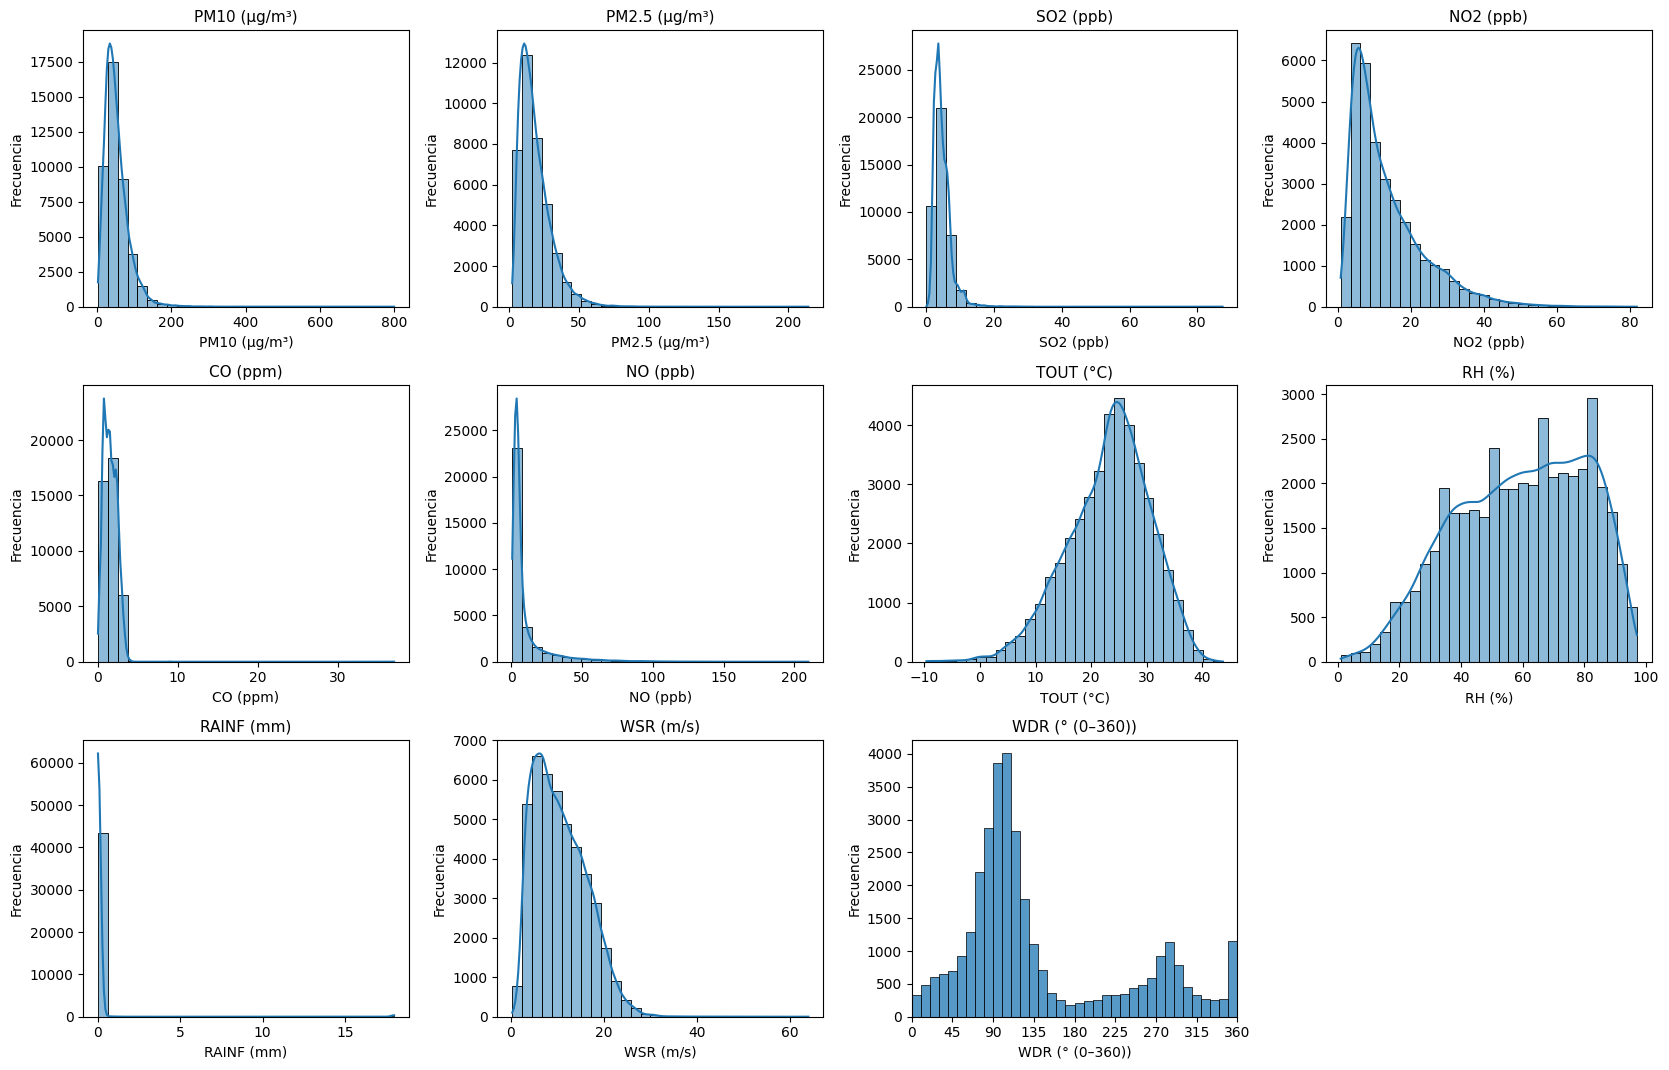

In [83]:

# ===================== USO =====================
# df = pd.read_csv("tus_datos.csv", parse_dates=["timestamp"])  # si tienes timestamp
# Elige explícitamente (recomendado):
vars_a_graficar = [c for c in CANDIDATES if c in df_sureste_crudos.columns]
plot_histograms(df_sureste_crudos, cols=vars_a_graficar, bins=30, kde=True, max_cols=4)

In [94]:
# Línea temporal de SO2
ax = (df_sureste_crudos
      .sort_values("timestamp")
      .set_index("timestamp")["SO2"]
      .plot(figsize=(10,4), title="SO₂ vs tiempo", ylabel="SO₂ (ppb)"))


KeyError: 'timestamp'

## Imputación de Datos